# Init

In [1]:
import sys
sys.path.insert(1, '../dstools')

In [2]:
from dstools.dataset import load_house_prices
from dstools.preprocess import TransformBinary, TransformColumn, TransformImputer, TransformNewColumn, TransformOthers, OrdinalEncoder
from dstools.preprocess import Pipeline

import seaborn as sns
import numpy as np
from scipy import stats

# Load Dataset

In [3]:
train, test = load_house_prices()
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 80)

In [5]:
test.shape

(1460, 81)

# Initial Analysis

The next cell create a pipeline, where is used to accumulate transformations of dataset.

In [6]:
pip = Pipeline()

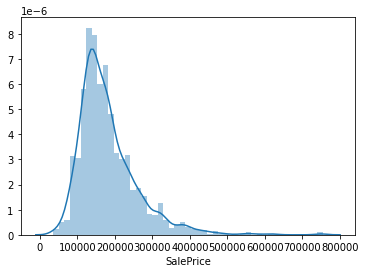

In [7]:
sns.distplot(train.SalePrice)

The target column no have a simetric distribution, normaly, it slow down the perfomance.

But this column have only positive values and possibly outliers, this a optmal cenary to use a logaritmic tranform, because this transformation "push" the distribution to the right.

In [8]:
tcol = TransformColumn({'SalePrice': np.log1p})

In [9]:
train = tcol.fit_transform(train)

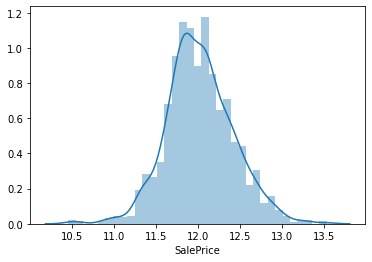

In [10]:
sns.distplot(train.SalePrice)

Now we go add function to a list os transformations.

In [11]:
pip.add(tcol)

In [12]:
pip.transformations

In [13]:
pip.is_fitted

True

Will be separate the columns by type to facility the analysis

The only non-ordinal columns, this columns will stay separate the rest of the dataset, in the final model we test this columns.

## NaN Values

Will be input non observed data for some columns

In [14]:
aux_nan = train.isna().mean().sort_values(ascending = False)
aux_nan = aux_nan[aux_nan > 0]
aux_nan

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageYrBlt     0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtQual        0.025342
BsmtCond        0.025342
BsmtFinType1    0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [15]:
def mode(x):
    return stats.mode(x).mode[0]

In [16]:
nan_impute = {
    'LotFrontage': ('Neighborhood', np.mean),
    'MasVnrArea': ('Neighborhood', np.mean),
    'Functional': 'Typ',
    'Electrical': 'SBrkr',
    'KitchenQual': 'TA',
    'MSZoning': ('MSSubClass', mode)
}

In [17]:
t_input = TransformImputer(nan_impute, not_input = ['SalePrice'])
t_input.fit(train)

In [18]:
t_input.fitted

True

In [19]:
pip.add(t_input)

In [20]:
train = t_input.transform(train)

In [21]:
aux_nan = train.isna().mean().sort_values(ascending = False)
aux_nan = aux_nan[aux_nan > 0]
aux_nan

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
GarageType      0.055479
GarageCond      0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrType      0.005479
dtype: float64

## Ordinal columns

For ordinal columns will be transform to numeric colmun.

In [22]:
ordinal_cols = {
    'Street':['Grvl','Pave'],
    'LotShape':['Reg','IR1','IR2','IR3'],
    'Utilities':['AllPub','NoSewr','NoSeWa','ELO','NAN'],
    'LandSlope':['Gtl','Mod','Sev'],
    'BldgType':['1Fam','2fmCon','Duplex','Twnhs','TwnhsE'],
    'ExterQual':['Ex','Gd','TA','Fa','Po'],
    'ExterCond':['Ex','Gd','TA','Fa','Po'],
    'BsmtQual':['Ex','Gd','TA','Fa','Po','NAN'],
    'BsmtCond':['Ex','Gd','TA','Fa','Po','NAN'],
    'BsmtExposure':['Gd','Av','Mn','No','NAN'],
    'BsmtFinType1':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NAN'],
    'BsmtFinType2':['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NAN'],
    'HeatingQC':['Ex','Gd','TA','Fa','Po'],
    'CentralAir':['N','Y'],
    'KitchenQual':['Ex','Gd','TA','Fa','Po','NAN'],
    'FireplaceQu':['Ex','Gd','TA','Fa','Po','NAN'],
    'GarageFinish':['Fin','RFn','Unf','NAN'],
    'GarageQual':['Ex','Gd','TA','Fa','Po','NAN'],
    'GarageCond':['Ex','Gd','TA','Fa','Po','NAN'],
    'PavedDrive':['Y','P','N'],
    'PoolQC':['Ex','Gd','TA','Fa','NAN'],
    'Fence':['GdPrv','MnPrv','GdWo','MnWw','NAN'],
}

In [23]:
tord = OrdinalEncoder(ordinal_cols)
tord.fit(train)
pip.add(tord)

In [24]:
train = tord.transform(train)

In [25]:
train[ordinal_cols.keys()].head(5)

,Street,LotShape,Utilities,LandSlope,BldgType,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,...,HeatingQC,CentralAir,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence
0,1,0,0,0,0,1,2,1,2,3,...,0,1,1,5,1,2,2,0,4,4
1,1,0,0,0,0,2,2,1,2,0,...,0,1,2,2,1,2,2,0,4,4
2,1,1,0,0,0,1,2,1,2,2,...,0,1,1,2,1,2,2,0,4,4
3,1,1,0,0,0,2,2,2,1,3,...,1,1,1,1,2,2,2,0,4,4
4,1,1,0,0,0,1,2,1,2,1,...,0,1,1,2,1,2,2,0,4,4


In [26]:
aux_nan = train.isna().mean().sort_values(ascending = False)
aux_nan = aux_nan[aux_nan > 0]
aux_nan

MiscFeature    0.963014
Alley          0.937671
GarageType     0.055479
MasVnrType     0.005479
dtype: float64

In [27]:
pip.transformations

In [28]:
pip.is_fitted

True

## Nominal columns

In [29]:
train.select_dtypes(np.object).head(5)

,MSZoning,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,HouseStyle,RoofStyle,RoofMatl,...,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,Functional,GarageType,MiscFeature,SaleType,SaleCondition
0,RL,NaN,Lvl,Inside,CollgCr,Norm,Norm,2Story,Gable,CompShg,...,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal
1,RL,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Story,Gable,CompShg,...,MetalSd,None,CBlock,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal
2,RL,NaN,Lvl,Inside,CollgCr,Norm,Norm,2Story,Gable,CompShg,...,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal
3,RL,NaN,Lvl,Corner,Crawfor,Norm,Norm,2Story,Gable,CompShg,...,Wd Shng,None,BrkTil,GasA,SBrkr,Typ,Detchd,NaN,WD,Abnorml
4,RL,NaN,Lvl,FR2,NoRidge,Norm,Norm,2Story,Gable,CompShg,...,VinylSd,BrkFace,PConc,GasA,SBrkr,Typ,Attchd,NaN,WD,Normal


In [30]:
t_others = TransformOthers()
t_others.fit(train)
pip.add(t_others)

In [31]:
pip.transformations

In [32]:
t_others.relevant_values

{'MSZoning': ['FV', 'RH', 'RL', 'RM'],
 'Alley': ['Grvl', 'Pave'],
 'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
 'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
 'Neighborhood': ['Blmngtn',
  'BrDale',
  'BrkSide',
  'ClearCr',
  'CollgCr',
  'Crawfor',
  'Edwards',
  'Gilbert',
  'IDOTRR',
  'MeadowV',
  'Mitchel',
  'NAmes',
  'NWAmes',
  'NoRidge',
  'NridgHt',
  'OldTown',
  'SWISU',
  'Sawyer',
  'SawyerW',
  'Somerst',
  'StoneBr',
  'Timber'],
 'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
 'Condition2': ['Norm'],
 'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
 'RoofStyle': ['Gable', 'Hip'],
 'RoofMatl': ['CompShg'],
 'Exterior1st': ['AsbShng',
  'BrkFace',
  'CemntBd',
  'HdBoard',
  'MetalSd',
  'Plywood',
  'Stucco',
  'VinylSd',
  'Wd Sdng',
  'WdShing'],
 'Exterior2nd': ['AsbShng',
  'BrkFace',
  'CmentBd',
  'HdBoard',
  'MetalSd',
  'Plywood',
  'Stucco',
  'VinylSd',
  'Wd Sdng',
  'Wd Shng'],
 'MasVnrType': ['BrkCmn', 'BrkFace', 'Non

In [33]:
train = t_others.transform(train)

## Numerical columns

Create new columns

In [34]:
new_cols = {
    'TotalBath': 'BsmtFullBath + 0.5*BsmtHalfBath + FullBath + 0.5*HalfBath',
    'TotalSqrFootage': 'BsmtFinSF1 + BsmtFinSF2 + 1stFlrSF + 2ndFlrSF',
    'TotalPorch': 'OpenPorchSF + 3SsnPorch + EnclosedPorch + ScreenPorch + WoodDeckSF'
}
t_newcol = TransformNewColumn(new_cols)
t_newcol.fit(train)
pip.add(t_newcol)

In [35]:
pip.transformations

In [36]:
train = t_newcol.fit_transform(train)

In [37]:
train[['TotalBath', 'TotalSqrFootage', 'TotalPorch']].describe()

,TotalBath,TotalSqrFootage,TotalPorch
count,1460.000000,1460.000000,1460.000000
mean,2.210616,1999.808219,181.329452
std,0.785399,773.992942,156.656097
min,1.000000,334.000000,0.000000
25%,2.000000,1493.000000,45.000000
50%,2.000000,1863.500000,164.000000
75%,2.500000,2383.500000,266.000000
max,6.000000,11286.000000,1027.000000


Now the objective is a discover the colums wich interessing to transform in binary columns.

This coluns problably will be bad features to model, so will binarize this columns.

In [38]:
t_bin = TransformBinary()
train = t_bin.fit_transform(train)
pip.add(t_bin)

In [39]:
t_bin.cols_bin

['bin_MSZoning_RL',
 'bin_Alley_Others',
 'bin_LandContour_Lvl',
 'bin_LotConfig_Inside',
 'bin_Condition1_Norm',
 'bin_RoofStyle_Gable',
 'bin_MasVnrType_None',
 'bin_Electrical_SBrkr',
 'bin_Functional_Typ',
 'bin_GarageType_Attchd',
 'bin_SaleType_WD',
 'bin_SaleCondition_Normal']

In [40]:
t_bin.cols_drop

['Condition2', 'RoofMatl', 'Heating', 'MiscFeature']

In [41]:
train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,Neighborhood,BldgType,HouseStyle,...,bin_LandContour_Lvl,bin_LotConfig_Inside,bin_Condition1_Norm,bin_RoofStyle_Gable,bin_MasVnrType_None,bin_Electrical_SBrkr,bin_Functional_Typ,bin_GarageType_Attchd,bin_SaleType_WD,bin_SaleCondition_Normal
0,60,65.0,8450,1,0,0,0,CollgCr,0,2Story,...,1,1,1,1,0,1,1,1,1,1
1,20,80.0,9600,1,0,0,0,Others,0,1Story,...,1,0,0,1,1,1,1,1,1,1
2,60,68.0,11250,1,1,0,0,CollgCr,0,2Story,...,1,1,1,1,0,1,1,1,1,1
3,70,60.0,9550,1,1,0,0,Crawfor,0,2Story,...,1,0,1,1,1,1,1,0,1,0
4,60,84.0,14260,1,1,0,0,NoRidge,0,2Story,...,1,0,1,1,0,1,1,1,1,1


The first objective is to research the columns that can cause mulcholinearity problem.

This columns will be separated to test in the final model.

# Test dataset

In [42]:
pip.transformations

In [44]:
test = pip.transform(test)

In [45]:
test.head(5)

,Id,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,Neighborhood,BldgType,...,bin_LandContour_Lvl,bin_LotConfig_Inside,bin_Condition1_Norm,bin_RoofStyle_Gable,bin_MasVnrType_None,bin_Electrical_SBrkr,bin_Functional_Typ,bin_GarageType_Attchd,bin_SaleType_WD,bin_SaleCondition_Normal
0,1,60,65.0,8450,1,0,0,0,CollgCr,0,...,1,1,1,1,0,1,1,1,1,1
1,2,20,80.0,9600,1,0,0,0,Others,0,...,1,0,0,1,1,1,1,1,1,1
2,3,60,68.0,11250,1,1,0,0,CollgCr,0,...,1,1,1,1,0,1,1,1,1,1
3,4,70,60.0,9550,1,1,0,0,Crawfor,0,...,1,0,1,1,1,1,1,0,1,0
4,5,60,84.0,14260,1,1,0,0,NoRidge,0,...,1,0,1,1,0,1,1,1,1,1


# Final transformation

In [46]:
import pandas as pd

In [47]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [48]:
train.head(5)

,MSSubClass,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,BldgType,OverallQual,OverallCond,...,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_Others,Foundation_PConc,Foundation_Slab
0,60,65.0,8450,1,0,0,0,0,7,5,...,0,0,1,0,0,0,0,0,1,0
1,20,80.0,9600,1,0,0,0,0,6,8,...,0,0,0,0,0,0,1,0,0,0
2,60,68.0,11250,1,1,0,0,0,7,5,...,0,0,1,0,0,0,0,0,1,0
3,70,60.0,9550,1,1,0,0,0,7,5,...,0,0,0,0,1,1,0,0,0,0
4,60,84.0,14260,1,1,0,0,0,8,5,...,0,0,1,0,0,0,0,0,1,0


# Model

In [50]:
import xgboost as xgb
# from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [51]:
def rmse(y_true, y_pred):       
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [52]:
xg = xgb.XGBRegressor()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns='SalePrice'),train['SalePrice'],
    train_size=0.75, test_size=0.25
)

In [54]:
xg.fit(X_train, y_train)

[19:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [56]:
rmse(np.expm1(xg.predict(X_test)), np.expm1(y_test))

28507.031209170742